<a href="https://colab.research.google.com/github/AkinoriTanaka-phys/HPC-Phys_tutorial_and_hands-on/blob/master/for_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1. マルコフ決定過程
---
### 1-1. 環境
強化学習は教師あり学習とは異なり、データを用いません。
代わりに**環境(Environment)**が与えられると考えます。
今回は事前に以下のセルを実行すれば読み込まれる「迷路」の環境を用いて説明します

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

import matplotlib.collections as mc
import copy

action2vect = {0: np.array([0, -1]),
               1: np.array([0, +1]),
               2: np.array([-1, 0]),
               3: np.array([+1, 0])
               }

a2m = {0:'up', 1:'down', 2:'left', 3:'right'}

def random_initialize(Maze):
    floor_labels = np.arange(len(Maze.floors))
    start_floor_label = np.random.choice(floor_labels)
    goal_floor_label = np.random.choice(floor_labels)
    #Maze.set_start(Maze.floors[start_floor_label].tolist())
    Maze.set_goal(Maze.floors[goal_floor_label].tolist())
    return Maze

def get_fig_ax(size=(8, 5)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return fig, ax
        
class MazeEnv():
    def __init__(self, lx, ly, threshold=0.9, figsize=5):
        self.lx = lx
        self.ly = ly
        self.create_maze_by_normal_distribution(threshold=threshold)
        self = random_initialize(self)
        
        self.action_space = [0,1,2,3]
        self.status = 'Initialized'
        self.figsize = figsize
        
    def reset(self, coordinate=[None, None]):
        """
        put the state at the start.
        """
        if coordinate[0]!=None:
            self.state = np.array(coordinate)
        else:
            #
            floor_labels = np.arange(len(self.floors))
            start_floor_label = np.random.choice(floor_labels)
            self.state = self.floors[start_floor_label]
            #
            #self.state = np.array(self.start)
        self.status = 'Reset'
        self.t = 0
        return self.get_state()
        
    def is_solved(self):
        """
        if the state is at the goal, returns True.
        """
        return self.goal==self.state.tolist()
    
    def get_state(self):
        """
        returns (x, y) coordinate of the state
        """
        return copy.deepcopy(self.state)#, copy.deepcopy(self.state[1])
            
    def step0(self, state, action):
        add_vector_np = action2vect[action]
        if (state+add_vector_np).tolist() in self.floors.tolist():
            next_state = state+add_vector_np
            self.status = 'Moved'
        else:
            next_state = state
            self.status = 'Move failed'
        self.t += 1
        return next_state
    
    def step1(self, state, action, state_p):
        if state_p.tolist()==self.goal:
            reward = 1
        elif False:
            reward = 0.1
        else:
            reward = 0
        return reward
    
    def step(self, action):
        state = self.get_state()
        next_state = self.step0(state, action)
        reward = self.step1(state, action, next_state)
        # self.state update
        self.state = next_state
        return self.get_state(), reward, self.is_solved(), {}
        
    def create_maze_by_normal_distribution(self, threshold):
        """
        creating a random maze.
        Higher threshold creates easier maze.
        around threshold=1 is recomended.
        """
        x = np.random.randn(self.lx*self.ly).reshape(self.lx, self.ly)
        y = (x < threshold)*(x > -threshold)
        self.tile = y
        self.load_tile()
        
    def load_tile(self):
        self.floors = np.array(list(np.where(self.tile==True))).T # (#white tiles, 2), 2 means (x,y) coordinate
        self.holes = np.array(list(np.where(self.tile==True))).T # (#black tiles, 2)

    def flip(self, coordinate=[None, None]):
        self.tile[coordinate[0], coordinate[1]] = not self.tile[coordinate[0], coordinate[1]]
        self.load_tile()
    
    def render_tile(self, ax, cmap='gray'):
        ax.imshow(self.tile.T, interpolation="none", cmap=cmap)
        return ax
    
    def render_arrows(self, ax, values_table):
        lx, ly, _ = values_table.shape
        vmaxs = np.max(values_table, axis=2).reshape(lx, ly, 1)
        vt = np.transpose(values_table*self.tile.reshape(lx, ly, 1)/vmaxs, (1,0,2))
        width = 0.5
        X, Y= np.meshgrid(np.arange(0, lx, 1), np.arange(0, ly, 1))
        ones = .5*np.ones(lx*ly).reshape(lx, ly)
        zeros= np.zeros(lx*ly).reshape(lx, ly)
        # up
        ax.quiver(X, Y, zeros, ones, vt[:,:,0], alpha=0.8, 
                      cmap='Reds', scale_units='xy', scale=1)
        # down
        ax.quiver(X, Y, zeros, -ones, vt[:,:,1], alpha=0.8, 
                      cmap='Reds', scale_units='xy', scale=1)
        # left
        ax.quiver(X, Y, -ones, zeros, vt[:,:,2], alpha=0.8, 
                      cmap='Reds', scale_units='xy', scale=1)
        # right
        ax.quiver(X, Y, ones, zeros, vt[:,:,3], alpha=0.8, 
                      cmap='Reds', scale_units='xy', scale=1)
        return ax
        
    def render(self, fig=None, ax=None, lines=None, values_table=None):
        canvas = False
        if ax!=None:
            pass
            canvas = True
            ax.clear()
        else:
            fig = plt.figure(figsize=(self.figsize, self.figsize))
            ax = fig.add_subplot(111)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
        ####
        ax = self.render_tile(ax)
        
        if values_table is not None:
            ax = self.render_arrows(ax, values_table)
        ####
        try:
            ax.scatter(self.start[0], self.start[1], marker='x', s=100, color='blue',
                       alpha=0.8, label='start')
        except AttributeError:
            pass
        try:
            ax.scatter(self.goal[0], self.goal[1], marker='d', s=100, color='red',
                       alpha=0.8, label='goal')
        except AttributeError:
            pass
        try:
            ax.scatter(self.state[0], self.state[1], marker='o', s=100, color='black',
                       alpha=0.8, label='agent')
        except AttributeError:
            pass
        if lines is not None:
            lc = mc.LineCollection(lines, linewidths=2, color='black', alpha=0.5)
            ax.add_collection(lc)
        else:
            pass
            
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                  scatterpoints=1)
        if canvas:
            #pass
            fig.canvas.draw()
        else:
            plt.show()
        
    def set_start(self, coordinate=[None, None]):
        if coordinate in self.floors.tolist():
            self.start = coordinate
        else:
            print('Set the start on a white tile.')
            
    def set_goal(self, coordinate=[None, None]):
        if coordinate in self.floors.tolist():
            self.goal = coordinate
        else:
            print('Set the goal on a white tile.')
                      
    def play(self, Agent, show=True):
        lines = []
        while not self.is_solved():
            state0 = self.get_state()
            action = Agent.play()
            self.step(action)
            state1 = self.get_state()
            lines.append([state0, state1])
            if show:
                self.render(lines=lines)
                
    def play_interactive(self, Agent):
        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(111)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        #self.render(fig=fig, ax=ax)
        lines = []
        while not self.is_solved():
            state0 = self.get_state()
            action = Agent.play()
            self.step(action)
            state1 = self.get_state()
            lines.append([state0, state1])
            #self.render(fig=fig, ax=ax, lines=lines)
            #fig.canvas.draw()
        self.render(fig=fig, ax=ax, lines=lines)
        plt.show()
        print("solved!")


class CliffEnv(MazeEnv):
    def __init__(self, lx, ly, threshold=0.9, figsize=5):
        self.lx = lx
        self.ly = ly
        self.create_cliff()
        self.start = [0, ly-1]
        self.goal = [lx-1, ly-1]
        
        self.action_space = [0,1,2,3]
        self.status = 'Initialized'
        self.figsize = figsize
        
    def reset(self, coordinate=[None, None]):
        """
        put the state at the start.
        """
        if coordinate[0]!=None:
            self.state = np.array(coordinate)
        else:
            self.state = np.array(self.start)
        self.status = 'Reset'
        self.t = 0
        return self.get_state()
    
    def create_cliff(self):
        """
        creating a cliff
        """
        x = np.ones(self.lx*self.ly).reshape(self.lx, self.ly)
        x[:, self.ly-1] -= 1
        x[0, self.ly-1] += 1
        x[self.lx-1, self.ly-1] += 1
        self.tile = x
        self.load_tile()
        
    def render_tile(self, ax, cmap='Reds_r'):
        ax.imshow(self.tile.T, interpolation="none", cmap=cmap)
        return ax
    
    def step0(self, state, action):
        add_vector_np = action2vect[action]
        if (state+add_vector_np).tolist() in self.floors.tolist():
            next_state = state+add_vector_np
            self.status = 'Moved'
        elif (state+add_vector_np).tolist() in self.holes.tolist():
            next_state = self.start
            self.status = 'Dropped'
        else:
            next_state = state
            self.status = 'Move failed'
        self.t += 1
        return next_state
    
    def step1(self, state, action, state_p):
        if state_p.tolist()==self.goal:
            reward = 1
        elif self.status=='Dropped':
            reward = -100
        else:
            reward = 0
        return reward

まずは迷路の環境を読み込んでみましょう：

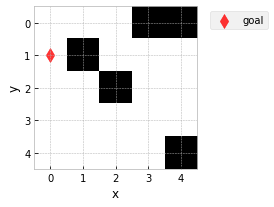

In [0]:
Env = MazeEnv(5,5, threshold=1., figsize=3) # threshold が大きいほど簡単な迷路
Env.render()

**`Env.render()`**は環境を表示させる関数です。環境の関数名はなるべく<a href="https://gym.openai.com">OpenAI Gym</a>を参考にしました。
> **【補足】** <a href="https://gym.openai.com">OpenAI Gym</a> はAtari社のブロック崩しゲームを始めとした、数々のゲームやその他の強化学習環境をpythonから呼び出すためのライブラリで、無料です。pipコマンドでダウンロードできます。

ここで
* ◾は通れない壁
* ◆ は迷路のゴール地点

を表すとします。早速この迷路のスタート地点に「プレイヤー」を置いてみましょう：

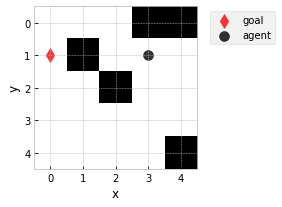

In [0]:
Env.reset() # 迷路の形はそのまま、ランダムなスタート地点にプレイヤー＝エージェントを置くコマンド
Env.render()

 ● が追加されました。これがプレイヤーの位置を表します。その座標(**状態(state)**といいます)は以下で確認できます：

In [0]:
Env.get_state() # array([x座標, y座標])が出力されます

array([3, 1])

プレイヤーは [↑、↓、←、→] を各座標で選択します。これを**行動(action)**と言います。行動のリストは：


In [0]:
Env.action_space

[0, 1, 2, 3]

後の便宜のため、[↑、↓、←、→] は `[0, 1, 2, 3]` で表現しています：

In [0]:
a2m = {0:'up', 1:'down', 2:'left', 3:'right'}

試しに ● を動かしてみましょう。それぞれ
* `Env.step0(s, a)`：**状態:`s`**に居るときに**行動:`a`**を取ったときの次の**状態**を返す
* `Env.step1(s, a, next_s)`：**状態:`s`**に居るときに**行動:`a`**を取り、**状態:`next_s`**に移った時の「**報酬(reward)**」の値を返す

時刻1, [3 1]->[4 1], by right-move, reward=0


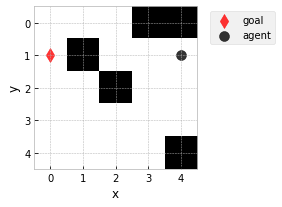

In [0]:
a = 3
s = Env.get_state()
##### 
next_s = Env.step0(s, a)
next_r = Env.step1(s, a, next_s)
Env.state = next_s # Env の内部状態を更新
#####
print("時刻{}, {}->{}, by {}-move, reward={}".format(Env.t, s, next_s, a2m[a], next_r))
Env.render()

真ん中の3行を毎回書くのは面倒なので
* `Env.step(a)`：上２つを同時に実行し、(**状態:`next_s`**, **報酬:`next_r`**, 解けたかどうか, 補足)を返す

を用意しました：

時刻2, [4 1]->[4 1], by up-move, reward=0


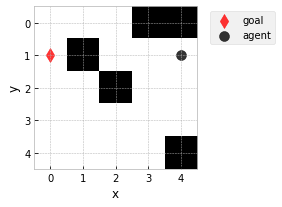

In [0]:
a = 0
s = Env.get_state()
#####
next_s, next_r, _, _ = Env.step(a) 
#####
print("時刻{}, {}->{}, by {}-move, reward={}".format(Env.t, s, next_s, a2m[a], next_r))
Env.render()

### ● ここまでのまとめ
- 登場する集合とその要素
 - **時刻**(状態、報酬、行動の添字) <br> $\quad T=\{0,1,2,3, \dots\}=\{t\}$<br/>
 - **状態**のとり得る集合（迷路だとプレイヤーのとり得るすべての座標\{`(x, y)`\}）<br/> $\quad S=\{s\}$<br/>
 - **報酬**の集合（迷路だと\{`0, 1`\} = \{解けてない, 解けた \}）<br/> $\quad R=\{r\}$<br/>
 - **行動**の集合（迷路だと\{`0, 1, 2, 3` \} = \{↑, ↓, ←, → \}）<br/> $\quad A=\{a\}$

- **環境**の持つ性質 (実装上は`Env.step(a)`で同時に計算)
 - $s_{t+1} = \text{step}_0(s_t, a_t)$
 - $r_{t+1} = \text{step}_1(s_t, a_t, s_{t+1})$

### ● より一般の環境について

上に書いた$\text{step}_{0, 1}$は関数なので、入力値が定まれば出力値は確定しています。
しかし、一般にはこれらが確定していない場合もあります。
> **【補足】** 例えば囲碁の盤面の**状態**とその時に置いた碁石の位置（**行動**）が何らかの具体的な値$(s_t, a_t)$を取ったからと言って、相手がどう出るかわからないので、次の自分の番での**状態** $s_{t+1}$が確定しているわけではありません。

このような場合も考慮に入れるために、確率的な定式化を導入します。P(x)から実際に値をサンプリングすることを

$$ x \sim P(x) $$

と書くことにすると、$P_s, P_r$をそれぞれ状態と報酬が与えられる確率だとして、
- **環境**の持つ性質(一般)
 - $s_{t+1} \sim P_s(s_{t+1}|s_t, a_t)$
 - $r_{t+1} \sim P_r(r_{t+1}|s_t, a_t, s_{t+1})$

と書けます。迷路のように決定している場合はデルタ関数などで表現できます。

---
### 1-2. エージェント
ここまでは手で操作してきました。つまり
* エージェント＝あなた自身

だったわけです。

あなた自身が迷路ゲームをプレイするとき、気分によって同じ座標に居ても↑だったり↓だったり選択するので、ゲームのプレイ方針は確率的といえるでしょう。このような「エージェントが持っているゲームのプレイ方針を記述する確率」を**方策(Policy)**といいます。

あなた自身の何らかの**方策**に基づいてエージェントを操作していたわけですが、強化学習ではその部分を機械に置き換えたいわけです。そうすると、機械のエージェントの実装に必要なのは**方策** と、それに従うゲームのプレイ＝**行動**のサンプリング、ですから

In [0]:
class Agent():
    def __init__(self, Policy):
        self.Policy = Policy
        
    def play(self):
        """
        return a number in [0,1,2,3] corresponding to [up, down, left, right]
        """
        return self.Policy.sample()

のような実装になるでしょう。ここで**方策**も何らかの条件付き確率で与えられることを前提としています：

- エージェントが持つべき性質
 - **方策**をあらわす条件付き確率<br/> $\quad \pi(a_t|s_t)$<br/>
 - そこからのサンプリング<br/> $\quad a_t \sim \pi(a_t|s_t)$<br/>


**`Policy`** はこの確率を記述するオブジェクトであり、**`Policy.sample()`**はサンプリングを記述するものです。

従って **`Policy`** は **`sample()`** 関数を持った何らかのオブジェクトとして

In [0]:
class Policy():
    def __init__(self):
        pass
    
    def sample(self):
        """
        プロトタイプなので pass とか適当でいいですが、後に
        [0,1,2,3] = [up, down, left, right] から一つ数を返す用に実装
        """
        action = None
        return action

のようなものを想定しています。たとえば、完全にランダムな方策

$$
\pi_\text{random}(a|s)
=
\frac{1}{|A|},
\quad
A = \{a\}
$$

は

In [0]:
class Random(Policy):
    def __init__(self, Env):
        self.A = Env.action_space # 迷路だと[0, 1, 2, 3]
        
    def sample(self):
        return np.random.choice(self.A) # np.random.choice(リスト)：リストから1つの要素をランダムサンプル

のように書けます。実際にこの方策を用いてゲームを1回プレイさせてみます：

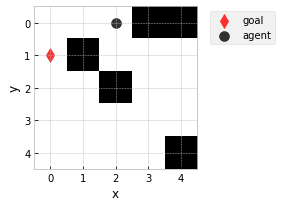

left


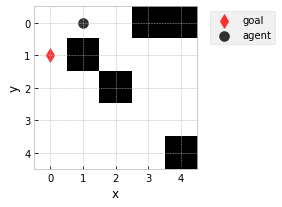

In [0]:
Agt = Agent(Policy=Random(Env)) # Random方策に基づく機械エージェント
Env.reset()
Env.render()

action = Agt.play()
print(a2m[action])
Env.step(action)
Env.render()

---
### 1-3. マルコフ決定過程

ここまでで
* **環境**：$\{ P_s(s_{t+1}|s_t, a_t), \ P_r(r_{t+1}|s_t, a_t, s_{t+1})\}$ = \{**状態**の時間発展,  **即時報酬**の時間発展 \}
* **エージェント**：$\{ \pi(a_t|s_t)\}$ = \{ **行動**の時間発展 \}

と3種類の確率変数$\{ s, r, a\}$についての時間発展を定義してきました。強化学習では、この3種類の確率変数の時間発展をゲームが終わるまで行います：

$$
\left. \begin{array}{ll:ll:ll:ll}
s_0 
\overset{\pi(\cdot|s_0)}{\to}
&
a_0 
\overset{P_s(\cdot|s_0, a_0)}{\to} 
&
s_1 
&
\overset{\pi(\cdot|s_1)}{\to}
a_1  
\overset{P_s(\cdot|s_1, a_1)}{\to} 
&
s_2
&
\overset{\pi(\cdot|s_2)}{\to}
a_2
\overset{P_s(\cdot|s_2, a_2)}{\to} 
&
 \cdots
\\
\downarrow_{P_r(\cdot|-, -, s_0)} 
&&
\downarrow_{P_r(\cdot|s_0, a_0, s_1)} 
&&
\downarrow_{P_r(\cdot|s_1, a_1, s_2)} 
\\
r_0
&
&
r_1
&
&
r_2
\end{array} \right.
$$

これを**マルコフ決定過程(Markov Decision Process, MDP)**といいます。


ゲームが始まってから終わるまでの1単位（**MDP**の1つのサンプル系列）を**エピソード(episode)**と呼びます。

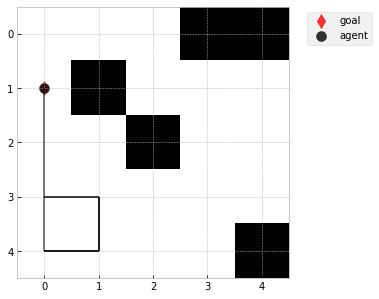

solved!


In [0]:
Agt = Agent(Policy=Random(Env)) # Random方策に基づく機械エージェント
Env.reset()
Env.play_interactive(Agt)

In [0]:
Env.t # 苦戦しすぎ

16

---
# 2. 価値推定に基づく学習アルゴリズム
---
## 2-1. 行動価値関数 $Q(s,a)$ と貪欲な方策
方策として前節の**`Random`**でもゲームのプレイは出来ましたが、当然ムダな動きが多いので、
* 各状態 s に対して「最適」な行動 a が存在するか？

というのは自然な問いでしょう。素朴には「得られる即時報酬の総和」$\sum_t r_t$ を最大化すれば良い気がしますが、よく取られるのは適当な減衰率 0<γ<1 を導入した、時刻t からの減衰和です：

$$
g_t = \sum_{k=0}^\infty \gamma^k r_{t+1+k}
$$

これを**収益(return)**といいます。

この値を MDP の系列の各時刻で最大にするようにしたいわけですが、$g_t, r_t$は確率変数なので、このままではゲームのプレイサンプル毎に値が変動してしまいます。

### ● 行動価値関数 $Q(s,a)$
そこでこれを、$P_s, P_r, \pi$の確率から成る MDP における期待値で表すことにします。

$$
Q(s, a) = \langle g_t \rangle_{(s_t, a_t)=(s,a)}
$$

これを**行動価値関数(action value function)**と言います。
MDPと並列して図示すると、

$$
\left. \begin{array}{l:r:ll:ll:l|l}
\dots
&
s, a
{\to} 
&
s_{t+1}
&
\overset{\pi(\cdot|s_{t+1})}{\to}
a_{t+1}
{\to} 
&
s_{t+2}
&
\overset{\pi(\cdot|s_{t+2})}{\to}
a_{t+2}
{\to} 
&
 \cdots
&
\\
&&
\downarrow
&&
\downarrow
\\
&&
r_{t+1}
&&
r_{t+2}
\\ \hline 
Q(s,a) =
&
\langle
&
r_{t+1}
&&
+\gamma r_{t+2}
&&
+ \dots
&
\rangle
\end{array} \right.
$$

のように、時刻 t で s に居て、そこで a を選んだとして、以後ずっと同じ方策$\pi$でゲームをプレイした時に得られる**収益**の期待値を表します。

> **【補足】** Q(s,a)は方策$\pi$に依存します

$Q(s,a)$の値が今回の機械学習で推定するターゲットというわけです。そのため、学習パラメータのクラスを

In [0]:
class Parameters():
    def __init__(self, Env, init=0.01):
        """
        s = (x, y)
        a \in [0,1,2,3]
        として
        self.values_table = Q[x, y, a] を表す
        """
        self.values_table = init*np.random.rand(Env.lx*Env.ly*4).reshape(Env.lx, Env.ly, 4)
        
    def get_values(self, s):
        """
        座標＝sでの[Q(s, a=0), Q(s, a=1), Q(s, a=2), Q(s, a=3)]
                      を返す
        """
        x, y = s # state
        return self.values_table[x, y, :]

とでもしておきましょう。

### ● greedy方策
$Q(s,a)$が**`Parameters`**クラスとして実装できたとしたとして、$Q$の意味を思い出してみると、方策として

$$
\pi_{greedy}(a|s)
=
\delta \Big(
a - 
\text{argmax}_{a'}\big\{ Q(s, a') \big\}
\Big)
$$

つまり、与えられた状態 s 毎に、行動価値観数が最大になる行動を取る方策を取れば良さそうです。これを**貪欲な方策(greedy policy)**と言います：

In [0]:
class Greedy(Policy):
    def __init__(self, Env, Q=None):
        self.Q = Q
        self.Env = Env # これは、やや冗長ですが Random と同じ使い方を想定しました
        
    def returns_action_from(self, values):
        action = np.argmax(values)
        return action
        
    def sample(self):
        Qvalues = self.Q.get_values(self.Env.state)
        return self.returns_action_from(Qvalues)

In [0]:
Pi = Greedy(Env=None, Q=None)
action = Pi.returns_action_from(values=[0,100,9,10])
action, a2m[action]

(1, 'down')

> **【補足】** np.argmax(リスト)は、リストに同じ値の最大値がある場合、一番添え字の若いものを選びます。

### ● ε-greedy方策
greedy方策には「遊び」がないため、局所解に囚われがちです。
そこでこれを修正した**ε-貪欲方策(ε-greedy policy)**というものがよく使われます

$$
\pi_{\epsilon\text{-}greedy}(a|s)
=
\left\{ \begin{array}{ll}
\pi_{greedy}(a|s) & (\text{w/ probability}\quad 1- \epsilon) \\
\pi_{random}(a|s) & (\text{w/ probability}\quad \epsilon)\\
\end{array} \right.
$$

> **【補足】** 強化学習における一つの大きな問題が「**探索と知識利用のトレードオフ(exploitation-exploration trade-offs)**」です。ε-greedy方策はεの値を調整することで、探索と知識利用の度合いを調整できます。

Greedyとほぼ同じ実装で出来ますので、ここには書きませんが、あとで使いますので、

以下を実行してください

In [0]:
class EpsilonGreedy(Greedy):
    def __init__(self, Env, Q, epsilon=0.1):
        super(EpsilonGreedy, self).__init__(Env, Q) # python 3 : super().__init__(Env, Q)で十分
        self.epsilon = epsilon
    
    def returns_action_from(self, values):
        if np.random.rand()<1-self.epsilon:
            action = np.argmax(values)
        else:
            action = np.random.choice(np.arange(len(values)))
        return action

In [0]:
Pi = EpsilonGreedy(Env=None, Q=None, epsilon=0.8)
a = Pi.returns_action_from(values=[0,100,9,10])
a, a2m[a]

(1, 'down')

### ● ここまでのまとめ
* **`Parameters`** : $Q(s,a)$の推定値のためのクラス
* **`Greedy(Policy)`** : 内部に`Parameters`インスタンスを持つgreedy方策
* **`Agent`** : 内部に`Policy`インスタンスを持つエージェントのクラス

を実装してきました。`Env`が迷路インスタンスだとして、
```
q = Parameters(Env)
Agt = Agent(Policy=Greedy(Env=Env, Q=q))
```
とすれば、`Env`に対して、適当に初期化されたQの推定値qに基づくgreedyなエージェントが作れたことになります。

### ● ここからやりたいこと
この**`q=Parameters(Env)`**を$Q(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle$
に設定して迷路を解けるようにしたいわけですが、これを直接計算せず、ゲームプレイの経験から推定することを考えます。この推定を行うクラス
* **`Optimizer`** : `Agent`を読み込み、学習させるクラス

を実装し、学習は
```
Opt = Optimizer(Agt)
...
Opt.update()
```
のように進めるとします。`Optimizer`のプロトタイプは以下のようなものです：

In [0]:
class Optimizer():
    def __init__(self, Agt):
        self.Agt = Agt
    
    def update(self):
        """
        なんかいい感じの処理
        """
        pass

以下では、この具体的な実装を考えていきます。

---
## 2-2. ベルマン方程式とSARSA

### ● ベルマン方程式
それを達成するために、$Q(s,q)$ がある漸化式を満たすことを示しましょう：

$$
\left. \begin{array}{ll}
Q(s, a) 
&=
\langle \underbrace{g_t}_\text{substitute def} \rangle_{(s_t, a_t)=(s,a)}
\\&=
\langle \underbrace{r_{t+1}}_{=:r_\text{next}} + \underbrace{\gamma r_{t+2} + \gamma^2 r_{t+3} + \cdots}_{\gamma g_{t+1}} \rangle_{(s_t, a_t)=(s,a)}
\\&=
\underbrace{ \langle r_\text{next} \rangle_{(s_t, a_t)=(s,a)} }_\text{only depends on $t$-th time evolution}
+
\gamma
\underbrace{\langle g_{t+1} \rangle_{(s_t, a_t)=(s,a)}}_{
\big\langle
\langle g_{t+1} \rangle_{(s_{t+1}, a_{t+1})=(s_\text{next}, a_\text{next})}
\big \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
}
\\&=
\langle r_\text{next} \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ r_\text{next} \sim P_r(\cdot|s, a, s_\text{next})}
+ \gamma \big\langle
\underbrace{\langle g_{t+1} \rangle_{(s_{t+1}, a_{t+1})=(s_\text{next}, a_\text{next})}}_{Q(s_\text{next}, a_\text{next})}
\big \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
\\&=
\langle r_\text{next} \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ r_\text{next} \sim P_r(\cdot|s, a, s_\text{next})}
+ \gamma \langle
Q(s_\text{next}, a_\text{next})
\rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
\end{array} \right.
$$

これを**ベルマン方程式(Bellman equation)**と言います。

> **【補足】** ここでは時間$t$は離散ですが、これを連続に拡張したほうが良い場合もあるでしょう（例えば実世界で動くエージェントの強化学習など）。連続時間への拡張は**ハミルトン-ヤコビ-ベルマン方程式(Hamilton-Jacobi-Bellman equation)**と呼ばれます。名前からわかるように古典力学におけるハミルトン-ヤコビ方程式の拡張になっているそうです。

### ● SARSA
ベルマン方程式の近似として、MDPのサンプル系列

$$
\left. \begin{array}{l:ll:ll:ll}
\dots
&
s
&
{\to}
a
{\to} 
&
s_\text{next}
&
{\to}
a_\text{next}
{\to} 
&
 \cdots
\\
&&&
\downarrow
\\
&
-
&&
r_\text{next}
\end{array} \right.
$$

があったとき、期待値をサンプルで近似すると

$$
Q(s, a) = r_\text{next} + \gamma Q(s_\text{next}, a_\text{next})
$$

としても良さそうです。つまり$q(s,a)$をモデルとして「誤差関数」

$$
l(q) = \frac{1}{2} 
\Big(q(s,a) - \big[ r_\text{next} + \gamma q(s_\text{next}, a_\text{next}) \big] \Big)^2
$$

を減らせば良さそうです。ニューラルネットの学習よろしく、勾配法でアップデートすることにすれば

$$
\left. \begin{array}{ll}
q(s,a) &\leftarrow 
q(s,a) - \eta \nabla_{q(s,a)} l(q)
\\
&= 
q(s,a) - \eta \underbrace{ \Big(q(s,a) - \big[ r_\text{next} + \gamma q(s_\text{next}, a_\text{next}) \big] \Big)}_\text{TD error}
\end{array} \right.
$$

を実際のMDPでのサンプル毎に更新すればよいでしょう。
更新する分の部分を**Temporal Difference error(TD error)**と言います。
TD errorの部分に順に$s, a, r_\text{next}, s_\text{next}, a_\text{next}$が出てきていることから、この方法を**SARSA**といいます。

In [0]:
class SARSA_optimizer(Optimizer):
    def __init__(self, Agt, eta, gamma):
        self.Agent = Agt
        self.Q = Agt.Policy.Q
        self.eta = eta
        self.gamma = gamma

    def update(self, s, a, r_next, s_next):
        a_next = self.Agent.play() # 一回プレイさせてa_nextをサンプル(環境には作用させない実装)
        TD_error = self.Q.get_values(s)[a] - (r_next + 
                                              self.gamma*self.Q.get_values(s_next)[a_next])
        self.Q.get_values(s)[a] -= self.eta*TD_error

早速これで強化学習させてみます：

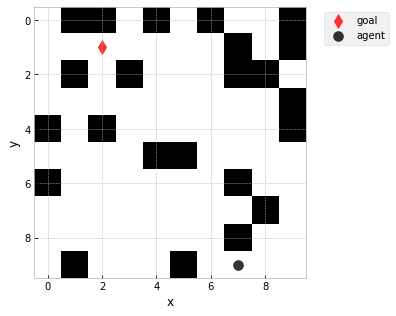

In [0]:
Env = MazeEnv(10, 10, threshold=1.2)
Env.reset()
Env.render()

In [0]:
%%time
q = Parameters(Env)
Agt = Agent(Policy=Greedy(Env=Env, Q=q))
Opt = SARSA_optimizer(Agt, eta=1., gamma=0.2)
N_episode = 6000

for episode in range(N_episode):
    Env.reset()
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        Opt.update(s, a, r_next, s_next)
        if Env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 3.06 s, sys: 3.84 ms, total: 3.07 s
Wall time: 3.07 s


学習後のエージェントで迷路を解かせてみます：

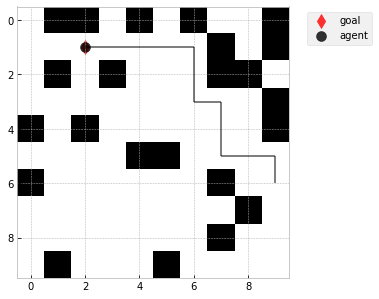

solved!


In [0]:
Env.reset()
Env.play_interactive(Agt)

`Env.render()`に推定された行動価値関数を図示するオプション
* `Env.render(values_table)`

を用意してみました。
濃い色ほど$Q(s,a)$の値が大きいことを意味します。

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


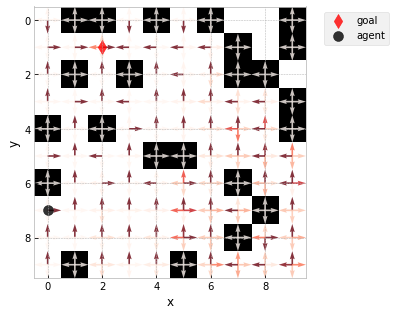

In [0]:
Env.reset()
Env.render(values_table=q.values_table)

---
## 2-3. Q学習
迷路は簡単な問題だったので、greedy方策+SARSAで十分高速に解けましたが、より難しく、探索が沢山必要な問題ではε-greedy方策を使ったほうが良い場合もあるでしょう。

試してみた方はわかると思いますが、迷路サイズが大きくなると、ε-greedy方策+SARSAはやや遅いです。greedy方策+SARSAが早かったのは、

$$
\left. \begin{array}{l:ll:ll:ll}
\dots
&
s
&
{\to}
a
{\to} 
&
s_\text{next}
&
\overset{\pi_{greedy}(\cdot|s_\text{next})}{\to}
a_\text{next}
{\to} 
&
 \cdots
\\
&&&
\downarrow
\\
&
-
&&
r_\text{next}
\end{array} \right.
$$

で $a_\text{next} = \text{argmax}_{a'}q(s_\text{next}, a')$ が最適であり、ゴールに設定された報酬がスタートに伝搬しやすくなっているためと考えられます。

そこで
$$
\left. \begin{array}{ll}
q(s,a) &\leftarrow 
q(s,a) - \eta \underbrace{ \Big(q(s,a) - \big[ r_\text{next} + \gamma q(s_\text{next}, a_\text{next}) \big] \Big)}_\text{TD error}
\end{array} \right.
$$

ではなく、

$$
\left. \begin{array}{ll}
q(s,a) &\leftarrow 
q(s,a) - \eta  \Big(q(s,a) - \big[ r_\text{next} + \gamma \max_{a'} q(s_\text{next}, a') \big] \Big)
\end{array} \right.
$$

とすることが考えられます。これを**Q学習(Q-learning)**といいます：

In [0]:
class Qlearning_optimizer(Optimizer):
    def __init__(self, Agt, eta, gamma):
        self.Agent = Agt
        self.Q = Agt.Policy.Q
        self.eta = eta
        self.gamma = gamma

    def update(self, s, a, r_next, s_next):
        # a_nextのサンプル無し
        error = self.Q.get_values(s)[a] - (r_next + 
                                           self.gamma*np.max(self.Q.get_values(s_next)))
                                                       # ↑ ここが変わった
        self.Q.get_values(s)[a] -= self.eta*error

一応デモンストレーション：

In [0]:
%%time
q = Parameters(Env)
Agt = Agent(Policy=EpsilonGreedy(Env=Env, Q=q))
Opt = Qlearning_optimizer(Agt, eta=1., gamma=0.2)
N_episode = 6000

for episode in range(N_episode):
    Env.reset()
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        Opt.update(s, a, r_next, s_next)
        if Env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 3.62 s, sys: 2.96 ms, total: 3.62 s
Wall time: 3.63 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


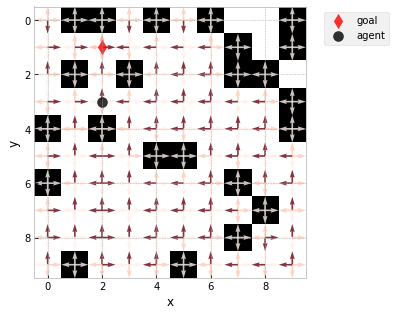

In [0]:
Env.reset()
Env.render(values_table=q.values_table)

## ● SARSAとQ学習の違い
SARSAは**方策オン**型、Q学習は**方策オフ**型と呼ばれます。詳細は
[別のノートブック(迷路ではなく、崖歩きの環境)](https://github.com/AkinoriTanaka-phys/HPC-Phys_tutorial_and_hands-on/blob/master/cliff_walkers.ipynb)
で説明していますので、興味あれば一読してみてください。
リンク先のノートブックのセルを実行するのに必要なものはすべて実装済みです。
実行してみたい人は以下に貼り付けたりしてみてください：

## ● Deep Q-Network (DQN)
**Q学習**と深層学習を組み合わせたのが**深層Q学習ネットワーク(Deep Q-Network, DQN)**です。
今回、実装はしませんが説明だけしておきます。論文はDeepMindによる
https://arxiv.org/abs/1312.5602
で、アルファ碁以前の深層強化学習論文だとおもいます。

これまでの
```
q = Parameters(Env)
```
では$Q(s, a)$の「テーブル」を用意して、テーブルの値をs, a毎に更新していたのでしたが、s, aの空間が巨大になると、必然的にテーブルも巨大になり、学習がはかどらなさそうです。

そこで、s を入力に取り、aの個数分の出力を持った深層ニューラルネット（**Deep Q-Network**）$f_Q$を導入し

$$
f_Q(s) =
\begin{pmatrix}
y_0 
\\
y_1 
\\
\vdots
\\
y_{\# a}
\end{pmatrix}
\approx
\begin{pmatrix}
Q(s, a=0)
\\
Q(s, a=1)
\\
\vdots
\\
Q(s, a=\# a)
\end{pmatrix}
$$

だと解釈します。`q = Parameters(Env)`のような (s, a) テーブルの代わりに、s$\to$a の関数を考えるのです。

ニューラルネットの出力値が$Q$の値になるようにするので、そのまま**Q学習**の考え方が使えます。Q学習は

$$
l(q) = \frac{1}{2} 
\Big(q(s,a) - \big[ r_\text{next} + \gamma \max_{a'}q(s_\text{next}, a') \big] \Big)^2
$$

の誤差関数を減少させる学習だったので、$q(s,a) = [f_Q(s)]_a$として、ニューラルネットの誤差関数をこれに設定：

$$
l(f_Q) = \frac{1}{2} 
\Big([f_Q(s)]_a - \big[ r_\text{next} + \gamma \max_{a'}[f_Q(s_\text{next})]_{a'} \big] \Big)^2
$$

し、勾配更新

$$
f_Q \leftarrow f_Q - \eta \nabla_{f_Q} l(f_Q)
$$

すればよいのです。実際にはこれだけでなく、いくつかの工夫を更に組み合わせますが、アイデアとしては単純なものです。論文では
* $s$:ゲームの画面のピクセル値
* $a$:コントローラーのボタン

という人間と対等な環境でAtari社のクラシックゲーム（ブロック崩しなど）を解かせています。例えば
https://www.youtube.com/watch?v=TmPfTpjtdgg
が公式？の動画ですが、0:50あたりまで見ると、ブロック崩しでブロックの裏側にボールを打ち出すテクニックが発見されたりして面白いです。
また
https://www.youtube.com/watch?v=MKtNv1UOaZA
などで、学習中の動画が見れます。

---
# 3. 方策最適化に基づく学習アルゴリズム
---
価値ベースの方法は、「行動空間」`Env.action_space` が巨大すぎる場合などではトレーニングに失敗することがあります。別の選択肢の 1 つは、値 Q(s,a) ではなく、ポリシー $\pi$ 自体のモデルを作成することです。

## 3-1. 状態価値関数、期待収益、方策勾配法
[Section2](https://github.com/AkinoriTanaka-phys/HPC-Phys_tutorial_and_hands-on/blob/master/section2.ipynb)
では行動価値関数を

$$
Q^\pi(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

としました。これは状態 s で行動 a を取った時の収益の期待値だったわけですが、これを更に a について方策で期待値を取ったもの

$$
V^{\pi}(s) = \langle Q^{\pi}(s, a) \rangle_{a \sim \pi(\cdot|s)}
$$

これは「方策 $\pi$ のもとで状態 s が持っている価値」を表し、**状態価値関数(state value function)** と呼ばれます。更に、迷路の実装を思い出すと

In [0]:
Env = MazeEnv(5,5, 1.2, figsize=3)

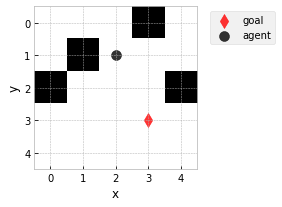

In [0]:
Env.reset() # 実行のたびにエージェントの位置が変わる
Env.render()

の**`Env.reset()`**は最初の状態 s をランダムに選んでいるのがわかります。この確率を $P_\text{reset}(s)$ とし、状態価値の期待値を取ると

$$
J(\pi) = \langle V^{\pi}(s) \rangle_{s \sim P_\text{reset} (\cdot)}
$$

となりますが、環境が固定されている以上この量は「方策にしか依存しない量」であり、かつ方策の良さを表す量（大きいほど良い）であると言えるでしょう。これを**期待収益(expected return)**といいます。

### ● 方策勾配法
そこで、価値の推定をすっ飛ばして、この$J(\pi)$を直接最大化する学習が考えられます。そのうちでも最も単純なのが
方策を θ でパラメーター化し

$$
\pi(a|s) = \pi_\theta(a|s)
$$

この時の期待収益を $\theta$ の関数と考え、勾配更新

$$
\theta \leftarrow \theta + \eta \nabla_\theta J(\pi_{\theta})
$$

によって学習を進めてゆくことです。これを**方策勾配法(Policy-gradient method)**といいます。

問題は方策勾配 $\nabla_\theta J(\pi_{\theta})$ をどうやって求めるのか、というところです。

---
## 3-2. 方策勾配定理とREINFORCEアルゴリズム
ここで少し定義を変更させてください。今までは行動価値観数を

$$
Q^\pi(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

と減衰和にしていましたが、ここからは

$$
Q^\pi(s,a) = 
\lim_{T \to \infty}
\langle \frac{1}{T}\sum_{k=0}^{T-1}  r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

と平均和の時間無限大極限に取ることにします。この場合のベルマン方程式は、

$$
Q^\pi(s,a) = \langle
Q^\pi(s_{+1}, a_{+1})
\rangle_{s_{+1} \sim P_s(\cdot|s, a),\ a_{+1} \sim \pi(\cdot | s_{+1})}
$$

となります。これを用いて方策勾配を求めてみましょう。まず状態価値観数の方策勾配から求めると

$$
\left. \begin{array}{rl}
\nabla_\theta \underbrace{ V^{\pi_\theta}(s) }_{\langle Q^{\pi_\theta} (s, a) \rangle_{a \sim \pi_\theta(\cdot|s)}}
&=
\nabla_\theta 
\sum_{a}
Q^{\pi_\theta} (s, a)
\pi_\theta(a|s)
\\
&=
\sum_{a}
\Big(
\underbrace{
\nabla_\theta 
Q^{\pi_\theta} (s, a)
}_{(*)}
\cdot
\pi_\theta(a|s)
+
Q^{\pi_\theta} (s, a)
\cdot
\underbrace{
\nabla_\theta 
\pi_\theta(a| s)
}_{\big(\nabla_\theta \log \pi_\theta(a | s)\big) \cdot \pi_\theta(a | s)}
\Big)
\\
&=
\sum_{a}
\Big(
(*)
+
Q^{\pi_\theta} (s, a)
\nabla_\theta \log \pi_\theta(a | s)
\Big) \cdot
\pi_\theta(a|s)
\\
&=
\big\langle
(*)
+
Q^{\pi_\theta} (s, a)
\nabla_\theta \log \pi_\theta(a | s)
\big\rangle_{a \sim \pi_\theta(\cdot|s)}
\end{array} \right.
$$

となって、行動価値関数の方策勾配を計算する必要に迫られます。しかしこれはベルマン方程式のため、再帰的に計算でき

$$
\left. \begin{array}{rl}
(*) &= 
\nabla_\theta 
\underbrace{Q^{\pi_\theta} (s, a)}_{Bellman}
\\
&=
\nabla_\theta 
\langle
Q^{\pi_\theta}(s_{+1}, a_{+1})
\rangle_{s_{+1} \sim P_s(\cdot|s, a),\ a_{+1} \sim \pi_\theta(\cdot | s_{+1})}
\\
&=
\nabla_\theta 
\sum_{s_{+1}, a_{+1}}
Q^{\pi_\theta}(s_{+1}, a_{+1})
\pi_\theta(a_{+1} | s_{+1})
P_s(s_{+1}|s, a)
\\
&=
\sum_{s_{+1}, a_{+1}}
\Big(
\underbrace{
\nabla_\theta 
Q^{\pi_\theta}(s_{+1}, a_{+1})
}_{(*)}
\cdot
\pi_\theta(a_{+1} | s_{+1})
+
Q^{\pi_\theta}(s_{+1}, a_{+1})
\cdot
\underbrace{
\nabla_\theta 
\pi_\theta(a_{+1} | s_{+1})
}_{\big(\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})\big) \cdot \pi_\theta(a_{+1} | s_{+1})}
\Big)
P_s(s_{+1}|s, a)
\\
&=
\sum_{s_{+1}, a_{+1}}
\Big(
(*)
+
Q^{\pi_\theta}(s_{+1}, a_{+1})\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})
\Big) \cdot
\pi_\theta(a_{+1} | s_{+1})
P_s(s_{+1}|s, a)
\\
&=
\big\langle
(*)
+
Q^{\pi_\theta}(s_{+1}, a_{+1})\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})
\big\rangle_{a_{+1} \sim \pi_\theta(\cdot | s_{+1}),\ s_{+1} \sim P_s(\cdot|s, a)}
\\
&=
\Big\langle
\sum_{t=0}^\infty
Q^{\pi_\theta}(s_{t+1}, a_{t+1})\nabla_\theta \log \pi_\theta(a_{t+1} | s_{t+1})
\Big\rangle_{MDP,\ (s_0, a_0)=(s, a)}
\end{array} \right.
$$

と書け、(*)をもとの V の勾配に代入すると $a_t = a$ として

$$
\nabla_\theta V(s)
=
\Big\langle
\sum_{t=0}^\infty
Q^{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP,\ s_0=s}
$$

更に**期待収益** $J(\pi_\theta)$は、これの初期状態による期待値なので、結局

$$
\nabla_\theta J(\pi_\theta)
=
\Big\langle
\sum_{t=0}^\infty
Q^{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP}
$$

が得られます。これを**方策勾配定理(Policy-gradient theorem)**と言います。

### ● REINFORCEアルゴリズム
実際には、期待値はサンプル$(r_t, s_t, a_t)$によって近似され

$$
\nabla_\theta J(\pi_\theta)
\approx
\sum_{t=0}^\infty
Q^{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
$$

とされますが、ここで結局 $Q^{\pi_\theta}(s_{t}, a_{t})$ が必要になってしまいました。この行動価値関数の意味は、収益の期待値だったわけですので、これを更に報酬のサンプルで適当な T (典型的にはサンプルのエピソード長さが使われる)

$$
Q^{\pi_\theta}(s_{t}, a_{t})
\approx
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}
$$

で近似することが考えられます。これを**REINFORCEアルゴリズム**と言います。すなわち、REINFORCEアルゴリズムとは
1. MDPサンプル$\{(r_t, s_t, a_t)\}_{t=0, 2, \dots, T-1}$を得る
2. $
\theta \leftarrow \theta + \eta g_\theta,\quad \text{where} \
g_\theta = \sum_{t=0}^\infty
\Big(
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}
\Big)
\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
$

を繰り返して、良い方策$\pi_\theta$を探索する手法のことです。
> **【補足】** MDPサンプルは一回の更新につきなるべく多く取ったほうが方策勾配$g_t$の精度が上がります。その場合はエピソード数$m = 0, 1, \dots, M-1$として$g_\theta = 
\frac{1}{M} \sum_{m=0}^{M-1}
\sum_{t=0}^\infty
\Big(
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}^{(m)}
\Big)
\nabla_\theta \log \pi_\theta(a_{t}^{(m)} | s_{t}^{(m)})$です。

---
## 3-3. Softmax方策による実装

実際にREINFORCEを実装するにあたって、**Softmax方策**というのを導入します。これは適当な関数 $f(s, a)$ を用いて

$$
\pi_f(a|s)
=
\frac{\exp\{f(s,a)\}}{\sum_{a'} \exp\{
f(s, a')
\}}
$$

とする方策です。[Section2](https://github.com/AkinoriTanaka-phys/HPC-Phys_tutorial_and_hands-on/blob/master/section2.ipynb)と同様に、$f(s,a)$をパラメータとして

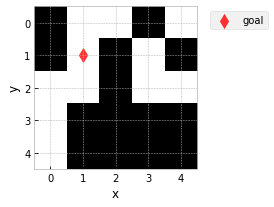

In [0]:
Env = MazeEnv(5,5, figsize=3)
f = Parameters(Env)
Env.render()

と実装してみます。Softmax方策を実装するにあたって、まずsoftmax関数

$$
\text{softmax}\Big(
\begin{pmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3 \\
\end{pmatrix}
\Big)
=
\frac{1}{
\exp\{x_0\}+\exp\{x_1\}+\exp\{x_2\}+\exp\{x_3\}
}
\begin{pmatrix}
\exp\{x_0\} \\
\exp\{x_1\} \\
\exp\{x_2\} \\
\exp\{x_3\} \\
\end{pmatrix}
$$

を実装しておきます：

In [0]:
def softmax(xs):
    sps = xs.shape
    num = np.exp(xs)
    den = np.sum(num, axis=2).reshape(sps[0], sps[1], 1)
    return num/den

こうしておいて、

In [0]:
class Softmax(Policy):
    def __init__(self, Env, f=None, temp=1):
        self.f = f
        self.Env = Env
        self.temp = temp
        
    def get_prob_table(self):
        fvalues_table = self.f.values_table
        #self.f.get_values(state)
        prob = softmax(fvalues_table/self.temp)
        return prob
    
    def get_prob(self, state):
        x, y = state
        return self.get_prob_table()[x, y, :]
        
    def sample(self):
        prob = self.get_prob(self.Env.state)
        action = np.random.choice(self.Env.action_space, p=prob)
               #p=prob のオプションは確率リストprobに従ってaction_spaceからサンプルする
        return action

で良いでしょう。（実装では**温度**`temp`を導入して確率をコントロールできるようにしました）

### ● 迷路の場合のREINFORCEアルゴリズム
迷路の環境では、時刻$t$で
* ゴールしていれば$r_t = 1$
* していなければ$r_t=0$

だったので、1エピソードで共通して方策勾配は

$$
g_\theta
=
\left\{ \begin{array}{ll}
\frac{1}{T} \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta (a_t|s_t) & (\text{if solved}) \\
0 & (\text{if unsolved}) \\
\end{array} \right.
$$

ということになります。この方策勾配はSoftmax方策だともう少し簡単化出来ます。ゴールした場合の勾配にSoftmaxを$\theta=f(s,a)$として代入してみると

$$
\left. \begin{array}{ll}
\frac{1}{T}
\sum_{t=0}^{T-1} \nabla_{f(s,a)} \log \pi_f (a_t|s_t) 
&=
\frac{1}{T}
\sum_{t=0}^{T-1} \nabla_{f(s,a)} \log 
\frac{\exp\{f(s_t,a_t)\}}{\sum_{a'} \exp\{
f(s_t, a')
\}}
\\
&=
\frac{1}{T}
\sum_{t=0}^{T-1} \nabla_{f(s,a)} 
\Big(
f(s_t,a_t)
-
\log \sum_{a'} \exp\{
f(s_t, a')
\}
\Big)
\\
&=
\frac{1}{T}
\sum_{t=0}^{T-1} 
\Big(
\overbrace{ \nabla_{f(s,a)} f(s_t, a_t)}^{\delta_{(s,a)=(s_t, a_t)}}
-
\frac{
\sum_{a''}
\overbrace{ \nabla_{f(s,a)} f(s_t, a'')}^{\delta_{(s,a)=(s_t, a'')}}
\cdot
\exp\{
f(s_t, a'')
\}
}{
\sum_{a'} \exp\{
f(s_t, a')
\}
}
\Big)
\\
&=
\frac{1}{T}
\sum_{t=0}^{T-1} 
\Big(
\delta_{(s,a)=(s_t, a_t)}
-
\delta_{s=s_t}
\underbrace{
\frac{
\exp\{
f(s_t, a)
\}
}{
\sum_{a'} \exp\{
f(s_t, a')
\}
}
}_{\pi_f(a|s_t)}
\Big)
\\
&=
\frac{1}{T}\Big(
N_{(s,a)}
-
N_s \pi_f(a|s)
\Big)
\end{array} \right.
$$

となるのがわかります。ここで
* $N_{(s,a)}$:エピソード中に状態 s で行動 a を選んだ回数
* $N_s$:エピソード中に状態 s を取った回数

を表すとします。

In [0]:
class REINFORCE_optimizer(Optimizer):
    def __init__(self, Agt, eta):
        self.Policy = Agt.Policy
        self.f = Agt.Policy.f
        self.Env = Agt.Policy.Env
        self.eta = eta
        self.N_sa = Parameters(self.Env, init=0) # N_{(s,a)}を数えるためParametersを利用
        self.N = 0 # 実際にself.fが更新された回数を数える。なくてもよい
            
    def update(self, s, a, r_next, s_next):
        x, y = s
        if self.Env.is_solved():
            self.N_sa.values_table[x, y, a] +=10 # 最後にボーナス（理論から外れるがこれがないと遅い）
            T = self.Env.t + 0.01 # オーバーフロー対策(たまに偶然ゴールに落とされてしまうので。。。)
            N_sa = self.N_sa.values_table # N_{(s,a)}を読み込む
            N_s = np.sum(N_sa, axis=2).reshape(self.Env.lx, self.Env.ly, 1)
            g = (N_sa - N_s*self.Policy.get_prob_table())/T # 方策勾配
            self.f.values_table += self.eta*g # 更新
            self.N += 1 # なくてもよい
        else:
            self.N_sa.values_table[x, y, a] +=1 # ここは必須、ゴールしてない時はN_{(s,a)}を更新
            
    def reset(self):
        self.N_sa.values_table[:,:,:] = 0*self.N_sa.values_table[:,:,:]
        # エピソードごとにN_{(s,a)}をリセットする。これは下の学習ループで唱える

学習させてみます

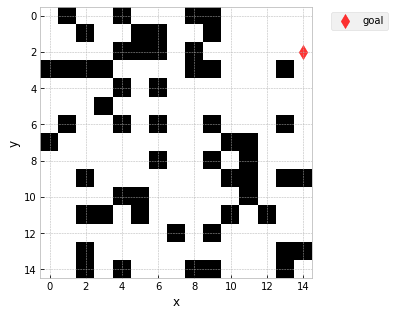

In [0]:
Env = MazeEnv(15,15, 1.2)
Env.render()

In [0]:
%%time
f = Parameters(Env)
Pi=Softmax(Env, f=f, temp=1)
Agt = Agent(Pi)
Opt = REINFORCE_optimizer(Agt, eta=10)
N_episode = 600 # 600でも十分

for episode in range(N_episode):
    Env.reset()
    Opt.reset() # !!! ここ重要　
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        if Env.status=='Moved':
            Opt.update(s, a, r_next, s_next)
        if Env.t > 60: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 3.09 s, sys: 1.45 ms, total: 3.1 s
Wall time: 3.1 s


In [0]:
Opt.N # 解けた回数＝実際の更新回数

342

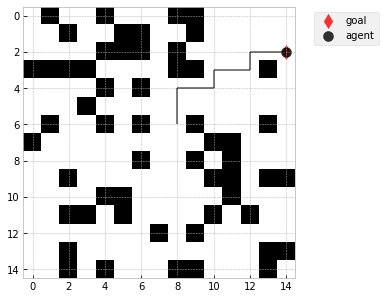

solved!


In [0]:
Env.reset()
Env.play_interactive(Agt)

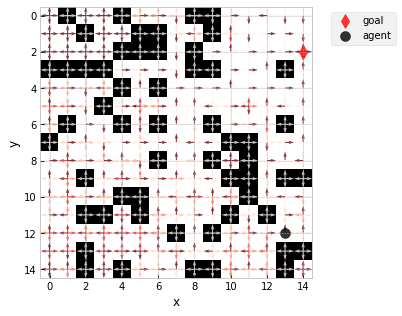

In [0]:
Env.reset()
Env.render(values_table=Pi.get_prob_table())